### Galaxy Zoo - The Galaxy Challenge
#### Baseline model
#### Author: Ching-Yin NG
#### Source code and report are available at https://github.com/alvinng4/GalaxyZooChallenge
#### Baseline model score: 0.07738
#### Baseline + CBAM: 0.07694
#### Baseline + EMA: 0.07653

Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses\
Q2. Is it edge-on? 2 responses\
Q3. Is there a bar? 2 responses\
Q4. Is there a spiral pattern? 2 responses\
Q5. How prominent is the central bulge? 4 responses\
Q6. Is there anything "odd" about the galaxy? 2 responses\
Q7. How round is the smooth galaxy? 3 responses\
Q8. What is the odd feature? 7 responses\
Q9. What shape is the bulge in the edge-on galaxy? 3 responses\
Q10. How tightly wound are the spiral arms? 3 responses\
Q11. How many spiral arms are there? 6 responses

## Import libraries

In [1]:
import csv
import itertools
import math
import pickle
import timeit
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

## Initialization

In [2]:
# Self-attention modules, only set one of them to True
USE_CBAM = False
USE_EMA = False

In [3]:
IMAGE_SIZE_BEFORE_SCALING = 256
TRAIN_SCALING_UPPER = IMAGE_SIZE_BEFORE_SCALING + 96
TRAIN_SCALING_LOWER = IMAGE_SIZE_BEFORE_SCALING - 72

OUTPUT_NUM_ROTATIONS = 32
OUTPUT_REFLECTION_FLAG = True

BATCH_SIZE = 105
FRACTION_FILES_VALIDATION = 0.1

In [4]:
RANDOM_STATE = 1


def seed_everything(seed: int):
    # random.seed(seed)
    # os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(RANDOM_STATE)

In [5]:
SUBCLASS_LEN = [3, 2, 2, 2, 4, 2, 3, 7, 3, 3, 6]
SUBCLASS_LEN_CUMSUM = np.cumsum(SUBCLASS_LEN)
CLASS_LEN = len(SUBCLASS_LEN)

FILE_PREFIX = "test"
OUTPUT_DIR = Path("output")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [6]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

True


## Import dataset

In [7]:
DATA_FOLDER = Path("data")

In [8]:
img_path = DATA_FOLDER / "images_training_rev1"
file_list = sorted([str(path) for path in img_path.glob("*.jpg")])
print(f"Number of data: {len(file_list)}")

train_sol_path = DATA_FOLDER / "training_solutions_rev1.csv"
train_sol = polars.read_csv(train_sol_path)
print("Some labels: ")
print(train_sol.head())

soft_labels = train_sol[:, 1:].to_numpy()

one_hot_labels = np.argmax(
    soft_labels[:, : SUBCLASS_LEN_CUMSUM[0]], axis=1
)  # Class one
for i in range(1, CLASS_LEN):
    one_hot_labels = np.vstack(
        (
            one_hot_labels,
            np.argmax(
                soft_labels[:, SUBCLASS_LEN_CUMSUM[i - 1] : SUBCLASS_LEN_CUMSUM[i]],
                axis=1,
            ),
        )
    )
one_hot_labels = one_hot_labels.T
print(soft_labels)
print(soft_labels.shape)
print(one_hot_labels)
print(one_hot_labels.shape)

Number of data: 61578
Some labels: 
shape: (5, 38)
┌──────────┬──────────┬──────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ GalaxyID ┆ Class1.1 ┆ Class1.2 ┆ Class1.3 ┆ … ┆ Class11.3 ┆ Class11.4 ┆ Class11.5 ┆ Class11.6 │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 100008   ┆ 0.383147 ┆ 0.616853 ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.325512  │
│ 100023   ┆ 0.327001 ┆ 0.663777 ┆ 0.009222 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100053   ┆ 0.765717 ┆ 0.177352 ┆ 0.056931 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100078   ┆ 0.693377 ┆ 0.238564 ┆ 0.068059 ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 100090   ┆ 0.933839 ┆ 0.0      ┆ 0.066161 ┆ … ┆ 0.0       ┆ 0.0  

In [9]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        label = self.labels[index]

        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.labels)


class TransformTrain:
    def __init__(self):
        self.rng = np.random.default_rng(seed=RANDOM_STATE)
        self.random_rotate = transforms.RandomRotation(360)
        self.transform_train = transforms.Compose(
            [
                transforms.Resize([128, 128]),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

    def __call__(self, x):
        rotated_img = self.random_rotate(x)
        random_crop_size = self.rng.integers(
            low=(TRAIN_SCALING_LOWER), high=(TRAIN_SCALING_UPPER)
        )
        cropped_image = transforms.functional.center_crop(
            rotated_img, [random_crop_size, random_crop_size]
        )

        return self.transform_train(cropped_image)


class TransformValid:
    def __init__(self):
        self.transform_valid = transforms.Compose(
            [
                transforms.CenterCrop(
                    [IMAGE_SIZE_BEFORE_SCALING, IMAGE_SIZE_BEFORE_SCALING]
                ),
                transforms.Resize([128, 128]),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

    def __call__(self, x):
        return self.transform_valid(x)

In [10]:
if FRACTION_FILES_VALIDATION > 0.0:
    (
        train_file_list,
        valid_file_list,
        train_soft_labels,
        valid_soft_labels,
    ) = train_test_split(
        file_list,
        soft_labels,
        test_size=FRACTION_FILES_VALIDATION,
        random_state=RANDOM_STATE,
        stratify=one_hot_labels[:, 0],
    )
else:
    train_file_list = file_list
    train_soft_labels = soft_labels

    valid_file_list = []
    valid_soft_labels = []

transform_train = TransformTrain()
train_dataset = ImageDataset(train_file_list, train_soft_labels, transform_train)
train_one_hot_labels_class_one = np.argmax(train_soft_labels[:, :3], axis=1)

if FRACTION_FILES_VALIDATION > 0.0:
    transform_valid = TransformValid()
    valid_dataset = ImageDataset(valid_file_list, valid_soft_labels, transform_valid)
    valid_one_hot_labels_class_one = np.argmax(valid_soft_labels[:, :3], axis=1)

print(f"Length of training files: {len(train_file_list)}")
print(f"Length of validation files: {len(valid_file_list)}")

print()
print("Class 1 distribution: ")
print(f"Training dataset: {Counter(train_one_hot_labels_class_one)}")
if FRACTION_FILES_VALIDATION > 0.0:
    print(f"Validation dataset: {Counter(valid_one_hot_labels_class_one)}")

Length of training files: 55420
Length of validation files: 6158

Class 1 distribution: 
Training dataset: Counter({1: 31343, 0: 24024, 2: 53})
Validation dataset: Counter({1: 3483, 0: 2669, 2: 6})


## Visualize the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.67058825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8352941].
Clipping input data to the valid range

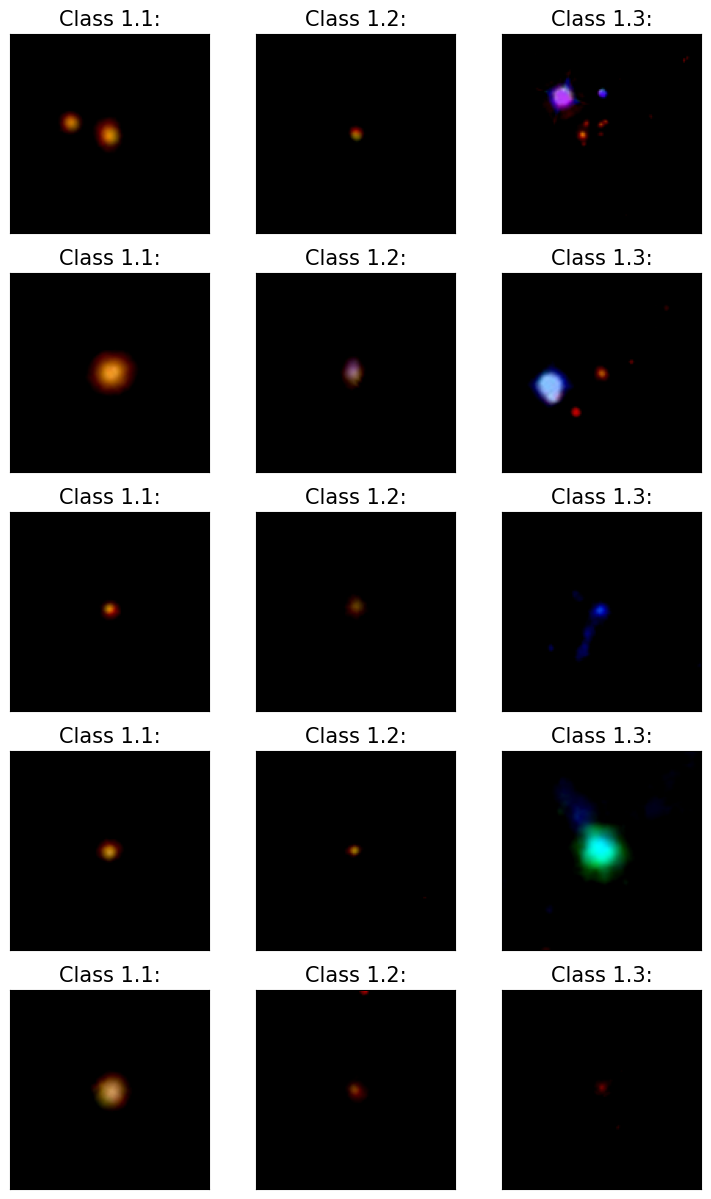

In [11]:
temp_data_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)

img_class_zero = []
img_class_one = []
img_class_two = []
img_per_class = 5

iter_data_loader = iter(temp_data_loader)
while True:
    img_batch, label_batch = next(iter_data_loader)
    for i in range(100):
        img = img_batch[i]
        label = label_batch[i]
        one_hot_label = np.argmax(label[:3])

        if (len(img_class_zero) < img_per_class) and (one_hot_label == 0):
            img_class_zero.append(img)
        elif (len(img_class_one) < img_per_class) and (one_hot_label == 1):
            img_class_one.append(img)
        elif (len(img_class_two) < img_per_class) and (one_hot_label == 2):
            img_class_two.append(img)

    if (
        (len(img_class_zero) >= img_per_class)
        and (len(img_class_one) >= img_per_class)
        and (len(img_class_two) >= img_per_class)
    ):
        break

fig1 = plt.figure(figsize=(9, 15))
for i in range(img_per_class):
    img = img_class_zero[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Class 1.1:", size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_one[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Class 1.2:", size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_class_two[i].cpu()
    ax = fig1.add_subplot(img_per_class, 3, (i * 3) + 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Class 1.3:", size=15)
    ax.imshow(img.permute(1, 2, 0))

plt.show()

## Creating a model

### Self-attention module (CBAM)

In [12]:
class channel_attention(nn.Module):
    def __init__(self, in_channels, reduction_ratio):
        super().__init__()
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        hidden_layer_size = int(in_channels // reduction_ratio)

        self.mlp = nn.Sequential()
        self.mlp.add_module("fc1", nn.Linear(in_channels, hidden_layer_size))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("fc2", nn.Linear(hidden_layer_size, in_channels))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = self.max_pool(x)
        avg_pooled_map = self.avg_pool(x)

        max_att_map = self.mlp(self.flatten(max_pooled_map))
        avg_att_map = self.mlp(self.flatten(avg_pooled_map))

        cha_att_map = self.sigmoid(max_att_map + avg_att_map).unsqueeze(2).unsqueeze(3)

        return cha_att_map


class spatial_attention(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=((kernel_size - 1) // 2),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_pooled_map = torch.amax(x, dim=1, keepdim=True)
        avg_pooled_map = torch.mean(x, dim=1, keepdim=True)

        concat_pooled_map = torch.cat((max_pooled_map, avg_pooled_map), dim=1)
        conv_map = self.conv(concat_pooled_map)
        spa_att_map = self.sigmoid(conv_map)

        return spa_att_map


class CBAM(nn.Module):
    """
    Convolutional Block Attention Module
    """

    def __init__(self, in_channels, cha_att_reduction_ratio, spa_att_kernel_size):
        super().__init__()
        self.channel_attention_module = channel_attention(
            in_channels, cha_att_reduction_ratio
        )
        self.spatial_attention_module = spatial_attention(spa_att_kernel_size)

    def forward(self, x):
        cha_att_map = self.channel_attention_module(x)
        spa_att_map = self.spatial_attention_module(x * cha_att_map)

        return x + (x * cha_att_map * spa_att_map)

### Self-attention module (EMA)

In [13]:
class EMA(nn.Module):
    """
    Efficient Multi-Scale Attention Module with Cross-Spatial Learning

    Source: https://github.com/YOLOonMe/EMA-attention-module/blob/main/EMA_attention_module
    """

    def __init__(self, in_channels, factor=32):
        super().__init__()
        self.groups = factor
        assert in_channels // self.groups > 0
        self.softmax = nn.Softmax(-1)
        self.agp = nn.AdaptiveAvgPool2d((1, 1))
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        self.gn = nn.GroupNorm(in_channels // self.groups, in_channels // self.groups)
        self.conv1x1 = nn.Conv2d(
            in_channels // self.groups,
            in_channels // self.groups,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.conv3x3 = nn.Conv2d(
            in_channels // self.groups,
            in_channels // self.groups,
            kernel_size=3,
            stride=1,
            padding=1,
        )

    def forward(self, x):
        b, c, h, w = x.size()
        group_x = x.reshape(b * self.groups, -1, h, w)  # b*g,c//g,h,w
        x_h = self.pool_h(group_x)
        x_w = self.pool_w(group_x).permute(0, 1, 3, 2)
        hw = self.conv1x1(torch.cat([x_h, x_w], dim=2))
        x_h, x_w = torch.split(hw, [h, w], dim=2)
        x1 = self.gn(group_x * x_h.sigmoid() * x_w.permute(0, 1, 3, 2).sigmoid())
        x2 = self.conv3x3(group_x)
        x11 = self.softmax(
            self.agp(x1).reshape(b * self.groups, -1, 1).permute(0, 2, 1)
        )
        x12 = x2.reshape(b * self.groups, c // self.groups, -1)  # b*g, c//g, hw
        x21 = self.softmax(
            self.agp(x2).reshape(b * self.groups, -1, 1).permute(0, 2, 1)
        )
        x22 = x1.reshape(b * self.groups, c // self.groups, -1)  # b*g, c//g, hw
        weights = (torch.matmul(x11, x12) + torch.matmul(x21, x22)).reshape(
            b * self.groups, 1, h, w
        )
        return (group_x * weights.sigmoid()).reshape(b, c, h, w)

### CNN model

In [14]:
if USE_CBAM is True:
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=17, padding=8),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        CBAM(in_channels=32, cha_att_reduction_ratio=4, spa_att_kernel_size=7),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, padding=6),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        CBAM(in_channels=64, cha_att_reduction_ratio=4, spa_att_kernel_size=7),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        CBAM(in_channels=128, cha_att_reduction_ratio=4, spa_att_kernel_size=7),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        CBAM(in_channels=256, cha_att_reduction_ratio=4, spa_att_kernel_size=7),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=96, kernel_size=1, padding=0),
        nn.BatchNorm2d(num_features=96),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(6144, SUBCLASS_LEN_CUMSUM[-1]),
        nn.Sigmoid(),
    )
elif USE_EMA is True:
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=17, padding=8),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        EMA(in_channels=32),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, padding=6),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        EMA(in_channels=64),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        EMA(in_channels=128),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        EMA(in_channels=256),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=96, kernel_size=1, padding=0),
        nn.BatchNorm2d(num_features=96),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(6144, SUBCLASS_LEN_CUMSUM[-1]),
        nn.Sigmoid(),
    )
else:
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=17, padding=8),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=13, padding=6),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=9, padding=4),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, padding=3),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=256, out_channels=96, kernel_size=1, padding=0),
        nn.BatchNorm2d(num_features=96),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(6144, SUBCLASS_LEN_CUMSUM[-1]),
        nn.Sigmoid(),
    )

In [15]:
x = torch.ones((4, 3, 128, 128))
print(model(x).shape)

torch.Size([4, 37])


In [16]:
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Sequential(
  (0): Conv2d(3, 32, kernel_size=(17, 17), stride=(1, 1), padding=(8, 8))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, 

In [17]:
model = model.to(device)

## Training

In [18]:
hist = [[], [], [], []]
lr_hist = []

In [19]:
def train(
    model,
    num_epochs,
    lr_scheduler,
    optimizer,
    train_dl,
    valid_dl,
    batch_size,
    hist,
    lr_hist,
    save_every_n_epochs,
):
    loss_fn = nn.MSELoss()
    previous_epochs = len(hist[0])

    for epoch in range(num_epochs):
        start = timeit.default_timer()
        model.train()
        i = 0
        loss_hist_train = 0
        rmse_hist_train = 0
        for x_batch, y_batch in train_dl:
            i += 1
            if i % 5 == 0:
                print(
                    f"Progress: epoch: {previous_epochs + epoch + 1}/{previous_epochs + num_epochs}, batch: {i}/{len(train_dl)}",
                    end="\r",
                )
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred.float(), y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train += loss.item() * y_batch.size(0)
            rmse_hist_train += mean_squared_error(
                y_true=y_batch.cpu(), y_pred=pred.detach().cpu()
            )

        loss_hist_train /= len(train_dl.dataset)
        rmse_hist_train /= len(train_dl.dataset) / batch_size
        rmse_hist_train = math.sqrt(rmse_hist_train)

        if FRACTION_FILES_VALIDATION > 0.0:
            model.eval()
            loss_hist_valid = 0
            rmse_hist_valid = 0
            with torch.no_grad():
                for x_batch, y_batch in valid_dl:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)
                    pred = model(x_batch)
                    loss = loss_fn(pred.float(), y_batch.float())

                    loss_hist_valid += loss.item() * y_batch.size(0)
                    rmse_hist_valid += mean_squared_error(
                        y_true=y_batch.cpu(), y_pred=pred.detach().cpu()
                    )

            loss_hist_valid /= len(valid_dl.dataset)
            rmse_hist_valid /= len(valid_dl.dataset) / batch_size
            rmse_hist_valid = math.sqrt(rmse_hist_valid)
        else:
            loss_hist_valid = 0.0
            rmse_hist_valid = 0.0

        end = timeit.default_timer()

        print_str = (
            f"Epoch: {previous_epochs + epoch + 1} "
            + f"train rmse: {rmse_hist_train:.4f} "
            + f"train loss: {loss_hist_train:.4f} "
            + f"val rmse: {rmse_hist_valid:.4f} "
            + f"val loss: {loss_hist_valid:.4f} "
            + f"lr: {lr_scheduler.get_last_lr()[0]} "
            + f"Time taken: {end - start:.3f}s"
        )
        print(print_str)

        if (previous_epochs + epoch + 1) % save_every_n_epochs == 0:
            torch.save(
                model,
                OUTPUT_DIR
                / f"{FILE_PREFIX}_model_epoch{previous_epochs + epoch + 1}.pth",
            )

        results = [loss_hist_train, loss_hist_valid, rmse_hist_train, rmse_hist_valid]
        for i in range(len(hist)):
            hist[i].append(results[i])
        lr_hist.append(lr_scheduler.get_last_lr()[0])

        lr_scheduler.step()

In [20]:
num_workers = (
    8  # num_workers must set to zero if the images are already transferred to the GPU
)

if num_workers == 0:
    train_dl = DataLoader(train_dataset, BATCH_SIZE, num_workers=0, shuffle=True)

    if FRACTION_FILES_VALIDATION > 0.0:
        valid_dl = DataLoader(valid_dataset, BATCH_SIZE, num_workers=0, shuffle=False)
    else:
        valid_dl = None
else:
    train_dl = DataLoader(
        train_dataset,
        BATCH_SIZE,
        num_workers=num_workers,
        persistent_workers=True,
        pin_memory=True,
        shuffle=True,
    )
    if FRACTION_FILES_VALIDATION > 0.0:
        valid_dl = DataLoader(
            valid_dataset,
            BATCH_SIZE,
            num_workers=num_workers,
            persistent_workers=True,
            pin_memory=True,
            shuffle=False,
        )
    else:
        valid_dl = None

/home/user/cyng/.conda/envs/adc/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

learning_rate = 0.0001
num_epochs = 240
save_every_n_epochs = 10

optimizer = Adam(model.parameters(), lr=learning_rate)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-8)

In [22]:
train(
    model,
    num_epochs,
    lr_scheduler,
    optimizer,
    train_dl,
    valid_dl,
    BATCH_SIZE,
    hist,
    lr_hist,
    save_every_n_epochs,
)

/home/user/cyng/.conda/envs/adc/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 train rmse: 0.1335 train loss: 0.0178 val rmse: 0.1408 val loss: 0.0197 lr: 0.0001 Time taken: 132.415s
Epoch: 2 train rmse: 0.1145 train loss: 0.0131 val rmse: 0.1214 val loss: 0.0147 lr: 9.999571680706248e-05 Time taken: 127.028s
Epoch: 3 train rmse: 0.1085 train loss: 0.0118 val rmse: 0.1119 val loss: 0.0124 lr: 9.998286796215299e-05 Time taken: 126.655s
Epoch: 4 train rmse: 0.1051 train loss: 0.0111 val rmse: 0.1164 val loss: 0.0135 lr: 9.996145566685496e-05 Time taken: 126.072s
Epoch: 5 train rmse: 0.1031 train loss: 0.0106 val rmse: 0.1055 val loss: 0.0111 lr: 9.993148359005493e-05 Time taken: 126.480s
Epoch: 6 train rmse: 0.1016 train loss: 0.0103 val rmse: 0.1035 val loss: 0.0107 lr: 9.989295686731399e-05 Time taken: 126.795s
Epoch: 7 train rmse: 0.1002 train loss: 0.0100 val rmse: 0.1006 val loss: 0.0100 lr: 9.984588209998776e-05 Time taken: 126.738s
Epoch: 8 train rmse: 0.0995 train loss: 0.0099 val rmse: 0.1048 val loss: 0.0109 lr: 9.979026735409523e-05 Time taken: 

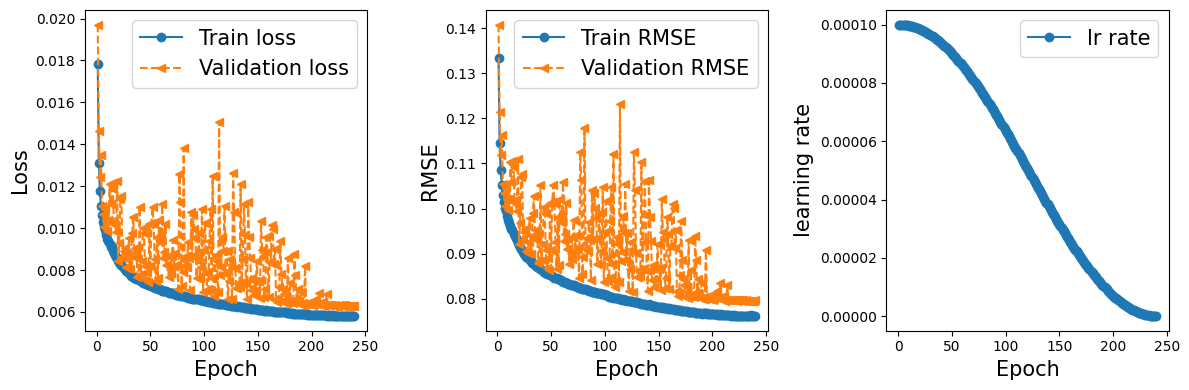

In [23]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
if FRACTION_FILES_VALIDATION > 0.0:
    ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)

ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist[2], "-o", label="Train RMSE")
if FRACTION_FILES_VALIDATION > 0.0:
    ax.plot(x_arr, hist[3], "--<", label="Validation RMSE")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("RMSE", size=15)

ax = fig.add_subplot(1, 3, 3)
ax.plot(x_arr, lr_hist, "-o", label="lr rate")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("learning rate", size=15)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"{FILE_PREFIX}_lr{learning_rate}.png")
plt.show()

with open(OUTPUT_DIR / f"{FILE_PREFIX}_hist.pkl", "wb") as file:
    pickle.dump(hist, file)

with open(OUTPUT_DIR / f"{FILE_PREFIX}_lr_hist.pkl", "wb") as file:
    pickle.dump(lr_hist, file)

## Test submission

In [2]:
final_test_img_path = DATA_FOLDER / "images_test_rev1"
final_test_file_list = sorted([str(path) for path in final_test_img_path.glob("*.jpg")])
print(f"Number of test files: {len(final_test_file_list)}")

Number of test files: 79975


In [3]:
class FinalTestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __getitem__(self, index):
        file = self.file_list[index]
        image = Image.open(file)

        if self.transform is not None:
            image = self.transform(image)

        gxy_id = Path(file).stem

        return image, gxy_id

    def __len__(self):
        return len(self.file_list)

In [4]:
class FixedRotation:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        return transforms.functional.rotate(img, self.angle)


class HorizontalFlip:
    def __call__(self, img):
        return transforms.functional.hflip(img)


class Identity:
    def __call__(self, x):
        return x


class TransformOutput:
    def __init__(self):
        fixed_rotates = [
            FixedRotation((360.0 / OUTPUT_NUM_ROTATIONS) * i)
            for i in range(OUTPUT_NUM_ROTATIONS)
        ]
        hflip = HorizontalFlip()
        identity = Identity()
        transform = transforms.Compose(
            [
                transforms.CenterCrop([IMAGE_SIZE_BEFORE_SCALING, IMAGE_SIZE_BEFORE_SCALING]),
                transforms.Resize([128, 128]),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
            ]
        )

        if OUTPUT_REFLECTION_FLAG is True:
            all_combinations = list(itertools.product(fixed_rotates, [hflip, identity]))
        else:
            all_combinations = list(itertools.product(fixed_rotates))
        self.all_transforms = [
            transforms.Compose([*comb, transform]) for comb in all_combinations
        ]

In [ ]:
num_output_files = 0
for transform in TransformOutput().all_transforms:
    final_test_dataset = FinalTestImageDataset(final_test_file_list, transform)
    final_test_dl = DataLoader(
        final_test_dataset,
        num_workers=0,
        persistent_workers=False,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    file_name = f"submission{int(num_output_files)}.csv"
    with open(file_name, "w", newline="") as submission_file:
        writer = csv.writer(submission_file)
        writer.writerow(
            [
                "GalaxyID",
                "Class1.1",
                "Class1.2",
                "Class1.3",
                "Class2.1",
                "Class2.2",
                "Class3.1",
                "Class3.2",
                "Class4.1",
                "Class4.2",
                "Class5.1",
                "Class5.2",
                "Class5.3",
                "Class5.4",
                "Class6.1",
                "Class6.2",
                "Class7.1",
                "Class7.2",
                "Class7.3",
                "Class8.1",
                "Class8.2",
                "Class8.3",
                "Class8.4",
                "Class8.5",
                "Class8.6",
                "Class8.7",
                "Class9.1",
                "Class9.2",
                "Class9.3",
                "Class10.1",
                "Class10.2",
                "Class10.3",
                "Class11.1",
                "Class11.2",
                "Class11.3",
                "Class11.4",
                "Class11.5",
                "Class11.6",
            ]
        )

        print("Getting test results from model...")
        model.eval()
        all_preds_soft_labels = np.zeros(
            (len(final_test_dataset), SUBCLASS_LEN_CUMSUM[-1])
        )
        gxy_ids = np.zeros((len(final_test_dataset),))
        i = 0
        with torch.no_grad():
            for img_batch, gxy_id_batch in final_test_dl:
                print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
                img_batch = img_batch.to(device)
                pred = model(img_batch)
                pred_soft_labels = pred.cpu().numpy()

                if len(pred_soft_labels) == BATCH_SIZE:
                    all_preds_soft_labels[i : (i + BATCH_SIZE)] = pred_soft_labels
                    gxy_ids[i : (i + BATCH_SIZE)] = gxy_id_batch
                    i += BATCH_SIZE
                else:
                    all_preds_soft_labels[i:] = pred_soft_labels
                    gxy_ids[i:] = gxy_id_batch
                    i += len(pred_soft_labels)
                    break

        print()
        print("Writing test results to submission file...")
        for i in range(len(all_preds_soft_labels)):
            print(f"Progress: {i + 1} / {len(all_preds_soft_labels)}", end="\r")
            output_list = [int(gxy_ids[i])] + all_preds_soft_labels[i].tolist()
            writer.writerow(output_list)

        print()
        print("Done!")
        num_output_files += 1

Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test results to submission file...
Progress: 79975 / 79975
Done!
Getting test results from model...
Progress: 79906 / 79975
Writing test resu

#### Averaging outputs

In [ ]:
def simple_averaging(file_list):
    n_files = len(file_list)
    avg_df = pd.read_csv(file_list[0])
    first_column = avg_df[["GalaxyID"]].copy()
    for i in range(1, n_files):
        avg_df += pd.read_csv(file_list[i])
    avg_df /= n_files
    avg_df = avg_df.drop(columns=["GalaxyID"])
    avg_df = pd.concat([first_column, avg_df], axis=1)
    avg_df.to_csv(f"submission.csv", index=False)


file_list = [f"submission{int(i)}.csv" for i in range(64)]
simple_averaging(file_list)